# Matching de Currículos com Carreiras com Modelos de Embeddings

## Importando bibliotecas necessárias

In [ ]:
# Importando bibliotecas essenciais
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics.pairwise import cosine_similarity
from PyPDF2 import PdfReader

# Bibliotecas de NLP
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

# Modelos de embeddings
from sentence_transformers import SentenceTransformer

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Baixando recursos do nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download("averaged_perceptron_tagger")


c:\Users\rapha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\rapha\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## Análise Exploratória

### Resumes Dataset

In [2]:
resume_df = pd.read_csv('resumes_dataset/Resume.csv')
resume_df.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [3]:
resume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2484 entries, 0 to 2483
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID           2484 non-null   int64 
 1   Resume_str   2484 non-null   object
 2   Resume_html  2484 non-null   object
 3   Category     2484 non-null   object
dtypes: int64(1), object(3)
memory usage: 77.8+ KB


In [4]:
resume_df = resume_df.drop(["Resume_html"], axis=1)
resume_df.head()

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR


In [5]:
resume_df.duplicated(subset=['Resume_str']).value_counts()

False    2482
True        2
Name: count, dtype: int64

In [6]:
resume_df = resume_df.drop_duplicates(subset=['Resume_str'], keep='first')
resume_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2482 entries, 0 to 2482
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ID          2482 non-null   int64 
 1   Resume_str  2482 non-null   object
 2   Category    2482 non-null   object
dtypes: int64(1), object(2)
memory usage: 77.6+ KB


### Job Descriptions Dataset

In [7]:
jobs_df = pd.read_csv('jobs_dataset/postings.csv')

In [8]:
jobs_df.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [9]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 31 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   job_id                      123849 non-null  int64  
 1   company_name                122130 non-null  object 
 2   title                       123849 non-null  object 
 3   description                 123842 non-null  object 
 4   max_salary                  29793 non-null   float64
 5   pay_period                  36073 non-null   object 
 6   location                    123849 non-null  object 
 7   company_id                  122132 non-null  float64
 8   views                       122160 non-null  float64
 9   med_salary                  6280 non-null    float64
 10  min_salary                  29793 non-null   float64
 11  formatted_work_type         123849 non-null  object 
 12  applies                     23320 non-null   float64
 13  original_liste

In [10]:
industries_df = pd.read_csv('jobs_dataset/companies/company_industries.csv')
industries_df.head()

,company_id,industry
0,391906,Book and Periodical Publishing
1,22292832,Construction
2,20300,Banking
3,3570660,Book and Periodical Publishing
4,878353,Staffing and Recruiting


In [11]:
industries_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24375 entries, 0 to 24374
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   company_id  24375 non-null  int64 
 1   industry    24375 non-null  object
dtypes: int64(1), object(1)
memory usage: 381.0+ KB


## Pré-Processamento de Texto

### Resumes Dataset

In [12]:
def extract_text_from_pdf(file_path):
    reader = PdfReader(file_path)
    text = "".join(page.extract_text() for page in reader.pages)
    return text

In [13]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Substituir caracteres não alfabéticos por espaços
    text = re.sub('[^a-zA-Z\s]', ' ', text)
    
    # Transformar o texto para letras minúsculas
    text = text.lower()
    
    # Tokenizar o texto em frases
    sentences = sent_tokenize(text)
    
    # Lista para armazenar palavras filtradas
    cleaned_text = []

    for sent in sentences:
        words = word_tokenize(sent)
        # Remover stopwords
        words = [word for word in words if word not in stop_words]
        # POS tagging para filtrar palavras irrelevantes
        tagged_words = pos_tag(words)
        # Filtrar palavras com tags irrelevantes
        filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
        # Adicionar as palavras filtradas à lista final
        cleaned_text.extend(filtered_words)
    
    # Retornar a string completa com as palavras limpas
    return " ".join(cleaned_text)

In [14]:
def preprocess_resume_data(df):
    file_path = f"resumes_dataset/resumes/{df['Category']}/{df['ID']}.pdf"
    resume_text = extract_text_from_pdf(file_path)
    return preprocess_text(resume_text)

In [15]:
tqdm.pandas()

resume_df['resume_preprocessed'] = resume_df.progress_apply(preprocess_resume_data, axis=1)

100%|██████████| 2482/2482 [05:48<00:00,  7.13it/s]


In [16]:
resume_df.head()

,ID,Resume_str,Category,resume_preprocessed
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR,hr administrator marketing associate hr admini...
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR,hr specialist hr operations summary media prof...
2,33176873,HR DIRECTOR Summary Over 2...,HR,hr director summary years experience recruitin...
3,27018550,HR SPECIALIST Summary Dedica...,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR MANAGER Skill Highlights ...,HR,hr manager skill highlights hr skills hr depar...


### Job Postings Dataset

In [28]:
import random

industry_list = random.sample(industries_df['industry'].unique().tolist(), 3)
print(industry_list)

['Higher Education', 'Printing Services', 'Software Development']


In [29]:
chosen_industries = industries_df[industries_df['industry'].isin(industry_list)]
chosen_industries.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1917 entries, 38 to 24325
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   company_id  1917 non-null   int64 
 1   industry    1917 non-null   object
dtypes: int64(1), object(1)
memory usage: 44.9+ KB


In [30]:
jobs_df = jobs_df[["company_id", "title", "description"]]
jobs_df.head()

,company_id,title,description
0,2774458.0,Marketing Coordinator,Job descriptionA leading real estate firm in N...
1,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ..."
2,64896719.0,Assitant Restaurant Manager,The National Exemplar is accepting application...
3,766262.0,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...
4,NaN,Service Technician,Looking for HVAC service tech with experience ...


In [31]:
jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123849 entries, 0 to 123848
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   company_id   122132 non-null  float64
 1   title        123849 non-null  object 
 2   description  123842 non-null  object 
dtypes: float64(1), object(2)
memory usage: 2.8+ MB


In [32]:
jobs_df.isnull().sum()

company_id     1717
title             0
description       7
dtype: int64

In [33]:
jobs_df = jobs_df.dropna()
jobs_df.isnull().sum()

company_id     0
title          0
description    0
dtype: int64

In [34]:
jobs_filtered = jobs_df.merge(chosen_industries[['company_id', 'industry']], on='company_id', how='inner')

In [35]:
jobs_filtered.head()

,company_id,title,description,industry
0,76987056.0,Software Engineer,Job Description:GOYT is seeking a skilled and ...,Software Development
1,166875.0,Coordinator for Multicultural Student Organiza...,The Coordinator serves as the principal adviso...,Higher Education
2,255252.0,Marketing Specialist,About TrackerTracker is a leading global cloud...,Software Development
3,14798.0,"Assistant Director of Admission, Midwest Regio...",Position OverviewButler University's Office of...,Higher Education
4,12977708.0,Account Executive - Mid-Market,"Here at Crisp, we value the strength in teamwo...",Software Development


In [36]:
jobs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377 entries, 0 to 7376
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   company_id   7377 non-null   float64
 1   title        7377 non-null   object 
 2   description  7377 non-null   object 
 3   industry     7377 non-null   object 
dtypes: float64(1), object(3)
memory usage: 230.7+ KB


In [37]:
tqdm.pandas()

jobs_filtered['description_preprocessed'] = jobs_filtered['description'].progress_apply(preprocess_text)

100%|██████████| 7377/7377 [01:19<00:00, 93.01it/s] 


In [38]:
jobs_filtered.head()

,company_id,title,description,industry,description_preprocessed
0,76987056.0,Software Engineer,Job Description:GOYT is seeking a skilled and ...,Software Development,job description goyt seeking skilled motivated...
1,166875.0,Coordinator for Multicultural Student Organiza...,The Coordinator serves as the principal adviso...,Higher Education,coordinator serves principal advisor aswsu sen...
2,255252.0,Marketing Specialist,About TrackerTracker is a leading global cloud...,Software Development,trackertracker leading global cloud based recr...
3,14798.0,"Assistant Director of Admission, Midwest Regio...",Position OverviewButler University's Office of...,Higher Education,position university office admission seeks dyn...
4,12977708.0,Account Executive - Mid-Market,"Here at Crisp, we value the strength in teamwo...",Software Development,crisp value strength teamwork strongly believe...


In [39]:
jobs_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7377 entries, 0 to 7376
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   company_id                7377 non-null   float64
 1   title                     7377 non-null   object 
 2   description               7377 non-null   object 
 3   industry                  7377 non-null   object 
 4   description_preprocessed  7377 non-null   object 
dtypes: float64(1), object(4)
memory usage: 288.3+ KB


## Extração de embeddings para o matching de vagas com currículos

In [40]:
# Modelo BERT pré-treinado
model = SentenceTransformer('bert-base-nli-mean-tokens')

# Gerar embeddings
def generate_embeddings(texts):
    embeddings = model.encode(texts, convert_to_tensor=True)
    return embeddings

In [41]:
# Gerar embeddings para os currículos
resume_embeddings = generate_embeddings(list(tqdm(resume_df['resume_preprocessed'].tolist(), desc="Gerando embeddings de currículos")))

Gerando embeddings de currículos: 100%|██████████| 2482/2482 [00:00<?, ?it/s]


c:\Users\rapha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


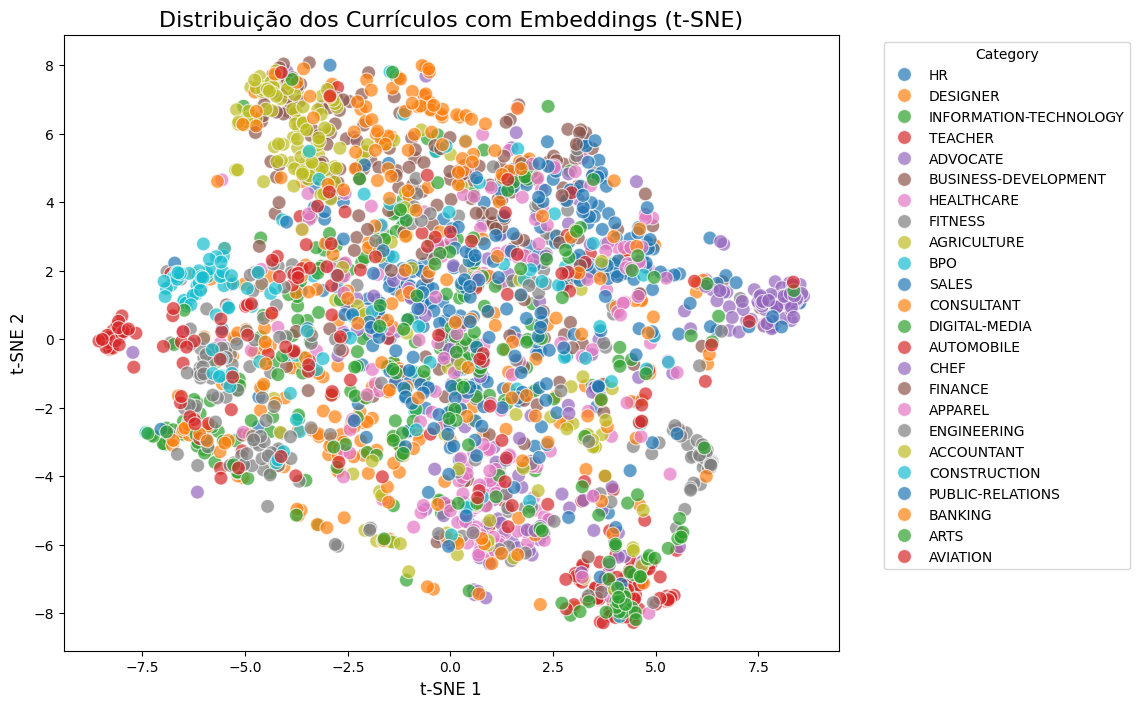

In [42]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(resume_embeddings)

tsne_df = pd.DataFrame(tsne_embeddings, columns=['t-SNE 1', 't-SNE 2'])
tsne_df['Category'] = resume_df['Category']

plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='Category', data=tsne_df, palette='tab10', s=100, alpha=0.7)

plt.title('Distribuição dos Currículos com Embeddings (t-SNE)', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [43]:
# Gerar embeddings para as descrições de vagas trabalho
job_description_embeddings = generate_embeddings(list(tqdm(jobs_filtered['description_preprocessed'].tolist(), desc="Gerando embeddings de descrições de vagas")))

Gerando embeddings de descrições de vagas: 100%|██████████| 7377/7377 [00:00<00:00, 3043913.49it/s]


c:\Users\rapha\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


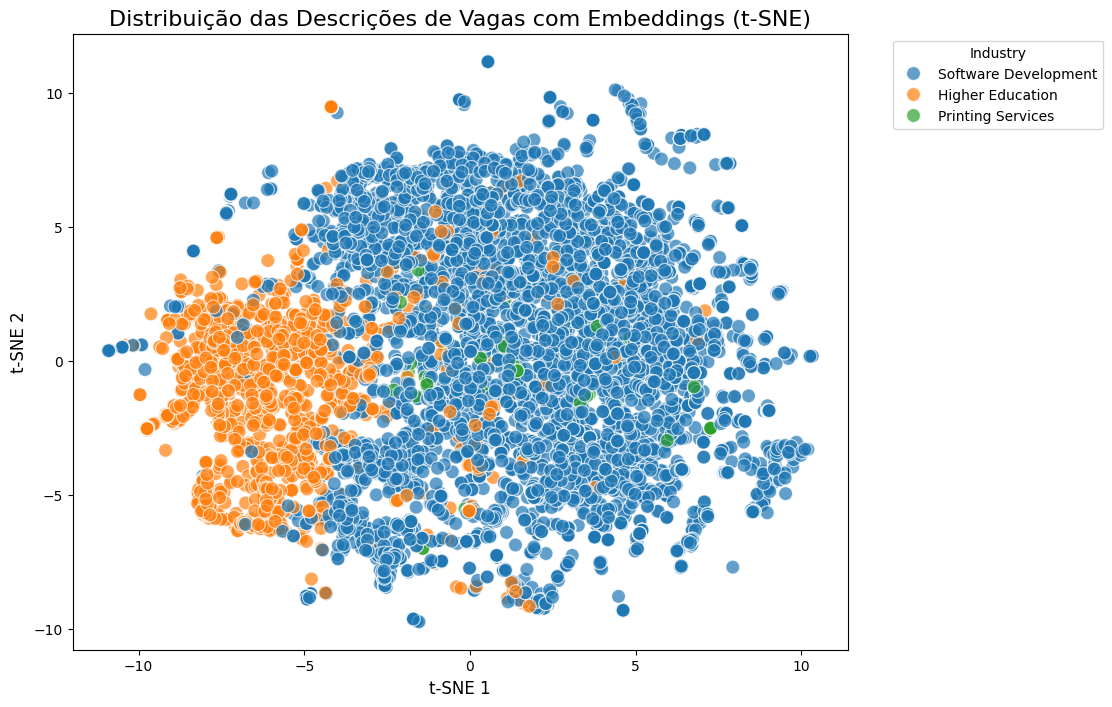

In [44]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(job_description_embeddings)

tsne_df = pd.DataFrame(tsne_embeddings, columns=['t-SNE 1', 't-SNE 2'])
tsne_df['industry'] = jobs_filtered['industry']

plt.figure(figsize=(10, 8))
sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='industry', data=tsne_df, palette='tab10', s=100, alpha=0.7)

plt.title('Distribuição das Descrições de Vagas com Embeddings (t-SNE)', fontsize=16)
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.legend(title='Industry', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [45]:
# Calcular a similaridade entre cada par de currículo e descrição
cosine_similarities = cosine_similarity(resume_embeddings, job_description_embeddings)

In [46]:
def get_top_n_similar_resumes(cosine_similarities, job_index, n=5):
    cosine_sim = cosine_similarities[:, job_index]
    
    top_n_indices = cosine_sim.argsort()[-n:][::-1]
    
    return top_n_indices, cosine_sim[top_n_indices]

In [47]:
for industry in jobs_filtered['industry'].unique():
    print("\n")
    print(f"Industry: {industry}")
    
    # Filtrar as vagas dessa indústria
    industry_jobs = jobs_filtered[jobs_filtered['industry'] == industry]
    
    # Selecionar 3 vagas aleatórias dessa indústria
    sampled_jobs = industry_jobs.sample(n=3)
    
    # Iterar sobre as vagas selecionadas
    for idx, job_row in sampled_jobs.iterrows():
        job_title = job_row['title']
        job_index = job_row.name
        
        # Obter os 5 currículos mais similares usando a matriz de similaridade
        top_resume_indices, similarities = get_top_n_similar_resumes(cosine_similarities, job_index)
        
        print(f"\nJOB: {job_title}")
        for resume_idx, sim in zip(top_resume_indices, similarities):
            resume_id = resume_df.iloc[resume_idx]['ID']
            print(f"Resume ID: {resume_id} | Similarity: {sim:.4f}")
        



Industry: Software Development

JOB: Fraud Prevention Manager
Resume ID: 98086373 | Similarity: 0.8510
Resume ID: 20357858 | Similarity: 0.8266
Resume ID: 21756639 | Similarity: 0.8214
Resume ID: 33286293 | Similarity: 0.8205
Resume ID: 16226743 | Similarity: 0.8140

JOB: Web Developer
Resume ID: 27040860 | Similarity: 0.8745
Resume ID: 25949631 | Similarity: 0.8644
Resume ID: 12144825 | Similarity: 0.8583
Resume ID: 21287405 | Similarity: 0.8574
Resume ID: 25023614 | Similarity: 0.8573

JOB: Senior-Security Engineering Manager, Product Security Foundations - Slack
Resume ID: 68240723 | Similarity: 0.9128
Resume ID: 12890045 | Similarity: 0.9121
Resume ID: 25813953 | Similarity: 0.9090
Resume ID: 13080868 | Similarity: 0.9089
Resume ID: 84512719 | Similarity: 0.9079


Industry: Higher Education

JOB: Entrepreneurship Apprentice
Resume ID: 16509761 | Similarity: 0.8949
Resume ID: 13080868 | Similarity: 0.8843
Resume ID: 28471099 | Similarity: 0.8835
Resume ID: 81508860 | Similarity: 0

In [50]:
print(resume_df[resume_df['ID'] == 27040860]["Resume_str"].iloc[0])
print(resume_df[resume_df['ID'] == 27040860]["Category"].iloc[0])

         ENGINEERING TECHNOLOGIST       Summary    To obtain a position within an organization that utilizes my skill set to continuously add vale and achieve best-in-class results Skills Profile
More than 10  years of successful experience in data analyzing, administrative and customer service roles with recognized strengths in account maintenance, problem-solving, thoroughness and extreme attention to detail
Efficient in self-motivating, prioritizing, multitasking, meeting deadlines and working in independent capacity or as part of a team
Proficient in Microsoft Office programs, OpenWells, Spotfire, SAP, Concur, QuickBooks and Adobe 
Ability to train, motivate and supervise while also being able to delegate to appropriate support roles in a professional and constructive manner
Keen on picking up on new experiences and learning quickly from others about the demands of the job
Skilled at analyzing and assessing data while then presenting it in an efficient and conclusive manner
Excelle

In [53]:
def mean_top_k_similarity(similarity_matrix, k=5):
    if hasattr(similarity_matrix, 'toarray'):
        similarity_matrix = similarity_matrix.toarray()

    similarity_averages = []

    for job_idx in range(similarity_matrix.shape[0]):
        similarities = similarity_matrix[job_idx].flatten()

        top_k_similarities = np.partition(similarities, -k)[-k:]

        similarity_averages.append(top_k_similarities.mean())

    return np.mean(similarity_averages)

In [56]:
print(mean_top_k_similarity(cosine_similarities, k=5))


0.88633835


In [57]:
def recommend_job(resume_text, job_descriptions_df, job_description_embeddings):

    # Gerar o embedding do currículo fornecido
    resume_embedding = generate_embeddings([resume_text])[0]
    
    # Calcular a similaridade entre o currículo e todas as descrições de vagas
    similarities = cosine_similarity([resume_embedding], job_description_embeddings)[0]
    
    # Encontrar o índice da vaga mais similar
    best_match_idx = np.argmax(similarities)
    
    # Obter a vaga correspondente
    best_job = job_descriptions_df.iloc[best_match_idx]
    best_similarity = similarities[best_match_idx]
    
    # Exibir a vaga mais similar
    print(f"Best Job Match: {best_job['title']}\n")
    print(f"Industry: {best_job['industry']}\n")
    print(f"Job Description: {best_job['description']}\n")
    print(f"Similarity: {best_similarity:.4f}\n")
    
    return best_job

resume_text = "Experienced software engineer with a background in machine learning, data analysis, and full-stack development."
best_job = recommend_job(resume_text, jobs_filtered, job_description_embeddings)

Best Job Match: Integrations Solutions Developer

Industry: Software Development

Job Description: Camgian is seeking an Integration Solutions Developer to build and maintain database and software integrations across various platforms for our company. In this role, you will identify, plan, and execute integration strategies, create tools for other developers, ensure ongoing monitoring, and maintain as well as optimize your builds. To ensure success as an Integration Solutions Developer, one will need to have analytical and problem-solving abilities, be able to work with multiple programming languages, databases, and API’s. Successful candidates can creatively solve integration problems and is comfortable writing and maintaining complex systems. The Integration Solutions Developer will play a crucial role in Camgian’s Operations team and the company’s ongoing digital transformation initiatives. Teamwork, flexibility, and willingness to continuously learn new tools & technologies are cri